# Candy features

The goal of this analysis is not to develop a model that can predict the popularity of a candy.
It is to **identify deciding features** that make a candy popular.

I am not training a predictive model.
1. The **dataset is too small** for meaningful prediction accuracy.
2. Most machine learning models are **black boxes** that will not offer any insight as to **what features are important**.

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, ttest_ind
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from statsmodels.stats.multitest import multipletests

Load the dataset

In [159]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/"
    "candy-data.csv",
    index_col=0
)

## Exploratory data analysis

### Data types and missing values

First look at the columns and data types to get a rough idea.

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 100 Grand to Whoppers
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chocolate         85 non-null     int64  
 1   fruity            85 non-null     int64  
 2   caramel           85 non-null     int64  
 3   peanutyalmondy    85 non-null     int64  
 4   nougat            85 non-null     int64  
 5   crispedricewafer  85 non-null     int64  
 6   hard              85 non-null     int64  
 7   bar               85 non-null     int64  
 8   pluribus          85 non-null     int64  
 9   sugarpercent      85 non-null     float64
 10  pricepercent      85 non-null     float64
 11  winpercent        85 non-null     float64
dtypes: float64(3), int64(9)
memory usage: 8.6+ KB


In [161]:
data.isna().sum()

chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

Most columns (or features, variables) are binary, denoting the presence or absence of certain flavor characteristics. There are no missing values, so no further data cleaning is necessary.

Sorting the candy by their `winpercent` reveals the best rated candy in descending order.

In [162]:
data.sort_values("winpercent", ascending=False).head(5)

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
Reese's Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
Reese's Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


### Distributions

Have a look at the distributions of each column to identify any skewed features that would impact analysis.

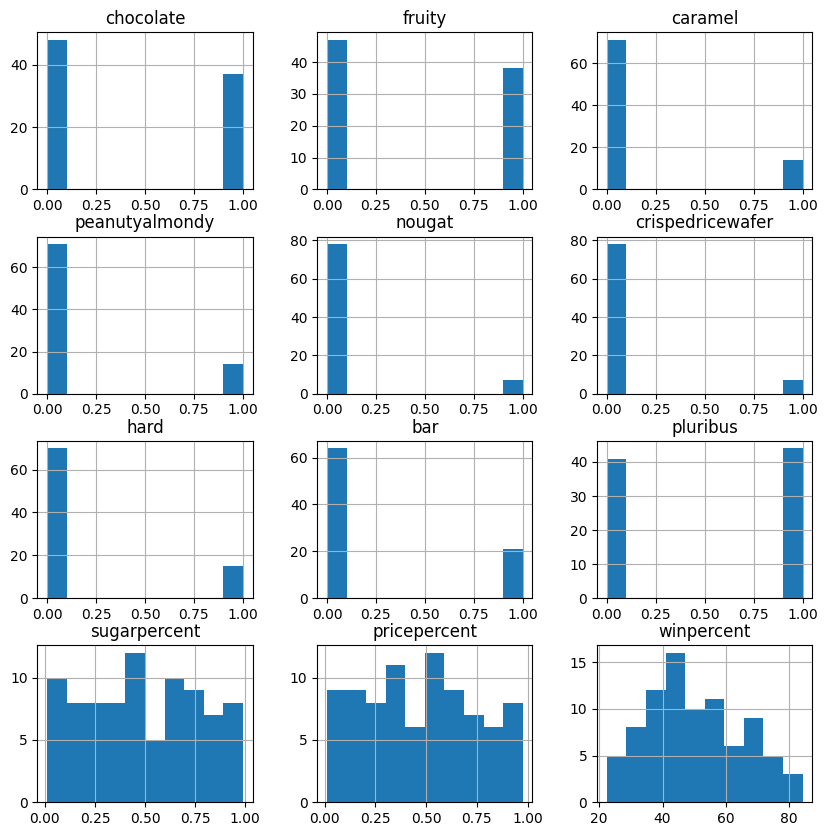

In [163]:
data.hist(figsize=(10, 10));

Some of the binary features are imbalanced:
- caramel
- peanutyalmondy
- nougat
- crispedricewafer
- hard
- bar

That means some of them are underrepresented in this dataset. That should be taken into account during analysis.

### Correlations

Inspect the collinearity between features.

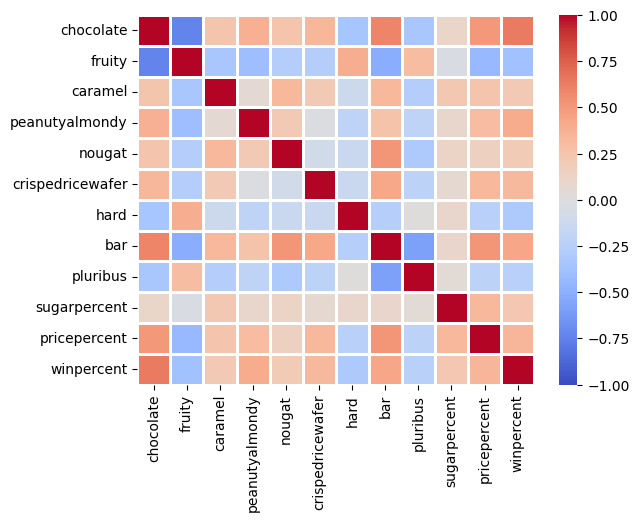

In [164]:
corr = data.select_dtypes('number').corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, linewidth=1);

Findings at first glance.

- If a candy is `fruity`, it is usually not `chocolate`, `caramel`, `peanutyalmondy`, `nougat`, `crispedricewafer`, `bar`.
- If a candy is a `bar`, it is usually not one of many in a bag or box (`pluribus`).
- The `winpercent` is correlated with `chocolate` and anti-correlated with `fruity`.
- The `sugarpercent` shows little correlation with any characteristics (aside from `pricepercent` and `winpercent`).
- `fruity`, `hard`, and `pluribus` candy show generally a low `winpercent`.

## Analysis

Let's now analyze the feature and which are deciding factors in the candy's popularity.

In [165]:
# Split data into features and target
X = data.copy()
y = X.pop("winpercent")

## Features from decision tree

I will first train a decision tree on the data. Not to predict the target, but to obtain a ranking of feature importance.

Because I am not interested in creating a prediction model, I am not splitting the data into training and testing set.

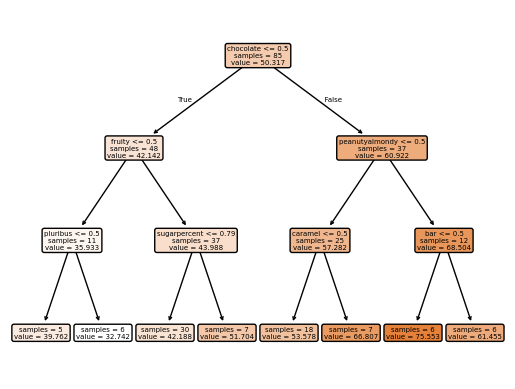

In [166]:
dt = DecisionTreeRegressor(max_depth=3, random_state=123)
dt.fit(X.drop(columns="pricepercent"), y)
plot_tree(dt, feature_names=X.columns, impurity=False, filled=True, rounded=True, fontsize=5);

From the visual depiction of the decision tree, I can get an idea about the important features: `chocolate` might be the most deciding factor, possibly followed by `fruity` and `peanutyalmondy`.

To put this into quantifiable numbers, let's use the more powerful random forrest and inspect the **feature importance**.

In [167]:
rf = RandomForestRegressor(n_estimators=1000, random_state=123)
rf.fit(X.drop(columns="pricepercent"), y)

feature_importance = pd.DataFrame(dict(Feature=X.drop(columns="pricepercent").columns,
                                       Importance=rf.feature_importances_))
feature_importance = feature_importance.sort_values("Importance", ascending=False)
feature_importance.head(5)

,Feature,Importance
0,chocolate,0.407535
9,sugarpercent,0.321935
3,peanutyalmondy,0.065435
1,fruity,0.040557
5,crispedricewafer,0.035834


This is a good initial understanding.
However, it is important to note that the decision tree and random forest might not do a great job at modelling the problem.

Instead, testing the statistical dependency of the win percentage to each feature will offer more insights.

## Statistical hypothesis testing on feature dependence

For assessing which features are the most important for making well-received candy, I will turn to statistical hypothesis testing.

For each feature, I will test whether it is independent from the target (`winpercent`).
Since the features are mostly binary categories, I will also make the target binary.
After all we are interested what makes a candy popular, not how popular a candy is in relative numbers.

Because the win percentage denotes how well a given candy is rated in relation to all the others, the 50% mark divides "good" from "bad" candy.

In [168]:
y_binary = y > 50

I will use a Chi-squared test for the categorical features and a t-test for the continuous features.

In [169]:
X_categorical = X.select_dtypes('int')  # For Chi-squared test
X_continuous = X.select_dtypes('float')   # For t-test

**Null-hypothesis:** The feature is independent from the target.

My goal is to reject the null hypothesis at a confidence level alpha of 0.05.
A probability of 5% of accepting a false-positive, seems reasonable for the business question.

In [170]:
alpha = 0.05

For the Chi-squared tests I will construct a contingency table for each feature-target combination. Here is one example of a contingency table:

In [171]:
pd.crosstab(y_binary, data.chocolate.astype("bool"))

chocolate,False,True
winpercent,,
False,37,9
True,11,28


I iterate over all features and obtain their p-value indicating whether the null-hypothesis is accepted or rejected.

In [172]:
pvalues = dict()

In [173]:
for col in X.columns:
    if col in X_categorical.columns:
        # Chi-squared test for categorical features
        contigency_table = pd.crosstab(y_binary, X_categorical[col])
        chi, pvalue, dof, exp = chi2_contingency(contigency_table)
        if exp.min() < 5:
            pvalue = fisher_exact(contigency_table)[1]
    else:
        # T-test for continuous features
        ttest, pvalue = ttest_ind(X_continuous.loc[y_binary, col],
                                  X_continuous.loc[~y_binary, col])
    # Store the p-value
    pvalues[col] = pvalue

In [174]:
# Make and sort DataFrame with selected features
selected_features = pd.DataFrame(list(pvalues.items()),
                                 columns=['feature', 'pvalue']).sort_values(by='pvalue')

Because I ran multiple tests, I need to perform Bonferroni correction on the alpha value (or the p-values) to account for the accumulated probabilities.

In [175]:
# Apply Bonferroni correction
p_values_list = selected_features['pvalue'].tolist()
significant, corrected_pvalues = multipletests(p_values_list, alpha=alpha, is_sorted=True,
                                               method='bonferroni')[:2]

# Add corrected p-values to the DataFrame
selected_features['corrected_pvalue'] = corrected_pvalues
selected_features['significant'] = significant

selected_features

,feature,pvalue,corrected_pvalue,significant
0,chocolate,0.000004,0.000042,True
7,bar,0.000531,0.005844,True
10,pricepercent,0.000679,0.007472,True
6,hard,0.002118,0.023293,True
3,peanutyalmondy,0.002891,0.031800,True
1,fruity,0.009364,0.103002,False
5,crispedricewafer,0.044367,0.488032,False
2,caramel,0.071010,0.781110,False
9,sugarpercent,0.094916,1.000000,False
4,nougat,0.239108,1.000000,False


From the dataframe above, I select the features that are marked with significant, that is, the features unlikely to be independent from the target.

In [176]:
selected_features = selected_features.loc[selected_features['significant'], ['feature',
                                                                             'corrected_pvalue']]
selected_features

,feature,corrected_pvalue
0,chocolate,0.000042
7,bar,0.005844
10,pricepercent,0.007472
6,hard,0.023293
3,peanutyalmondy,0.031800


Let's inspect the dependent features further:

- `pricepercent` does not offer any information with regard to the business question: The retail price of a candy is not likely causally related to its taste. If anything, it's probably the other way around or a mere correlation to the popularity of its brand.

In [177]:
selected_features = selected_features[selected_features.feature != "pricepercent"]
selected_features

,feature,corrected_pvalue
0,chocolate,0.000042
7,bar,0.005844
6,hard,0.023293
3,peanutyalmondy,0.031800


In [178]:
selected_features = selected_features.feature.tolist()

## Feature interaction

Next, we can inspect the collinearity of the selected features with the other features.

An absolute correlation of 0.3 is a common threshold.

In [179]:
threshold = 0.3

In [180]:
corr = X.corr().abs()

# Filter for strong correlations
strong_corr = corr.loc[selected_features, :].stack().reset_index()
strong_corr = strong_corr[(strong_corr[0] >= threshold) &
                          (strong_corr.level_0 != strong_corr.level_1)]
strong_corr.columns = ['feature1', 'feature2', 'correlation']

# Remove duplicates
strong_corr = strong_corr.drop_duplicates(subset=['feature1', 'feature2'])
pairs = []
to_drop = []
for i, corr0 in strong_corr.iterrows():
    pair = set(corr0[["feature1", "feature2"]])
    if pair not in pairs:
        pairs.append(pair)
    else:
        to_drop.append(i)
strong_corr = strong_corr.drop(to_drop, axis=0)

From the determined pairs, create interaction terms.

In [181]:
for index, row in strong_corr.iterrows():
    interaction_term = row['feature1'] + "_" + row['feature2']
    X[interaction_term] = X[row['feature1']] * X[row['feature2']]

Now repeat the hypothesis testing to find, if there are interesting combinations to consider.

In [182]:
inter_feat = X.columns[X.columns.str.contains('_')]

X_categorical = X.select_dtypes('int')  # For Chi-squared test
X_continuous = X.select_dtypes('float')   # For t-test

In [183]:
for col in inter_feat:
    if col in X_categorical.columns:
        # Chi-squared test for categorical features
        contigency_table = pd.crosstab(y_binary, X_categorical[col])
        chi, pvalue, dof, exp = chi2_contingency(contigency_table)
        if exp.min() < 5:
            pvalue = fisher_exact(contigency_table)[1]
    else:
        # T-test for continuous features
        ttest, pvalue = ttest_ind(X_continuous.loc[y_binary, col],
                                  X_continuous.loc[~y_binary, col])
    # Store the p-value
    pvalues[col] = pvalue

Again, apply the Bonferroni correction to obtain a file set of significantly dependent features.

In [184]:
# Make and sort DataFrame with selected features
selected_features = pd.DataFrame(list(pvalues.items()),
                                 columns=['feature', 'pvalue']).sort_values(by='pvalue')
selected_features

# Apply Bonferroni correction
p_values_list = selected_features['pvalue'].tolist()
significant, corrected_pvalues = multipletests(p_values_list, alpha=alpha, is_sorted=True,
                                               method='bonferroni')[:2]

# Add corrected p-values to the DataFrame
selected_features['corrected_pvalue'] = corrected_pvalues
selected_features['significant'] = significant

# Only keep significant features
selected_features = selected_features.loc[selected_features['significant'], ['feature',
                                                                             'corrected_pvalue']]

# Remove interaction terms with pricepercent
selected_features = selected_features[~selected_features.feature.str.contains("pricepercent")]

selected_features

,feature,corrected_pvalue
0,chocolate,0.000104
15,chocolate_bar,0.004623
12,chocolate_peanutyalmondy,0.004831
7,bar,0.014343
19,bar_caramel,0.034518


From the first three, create a relative importance from the p-value.

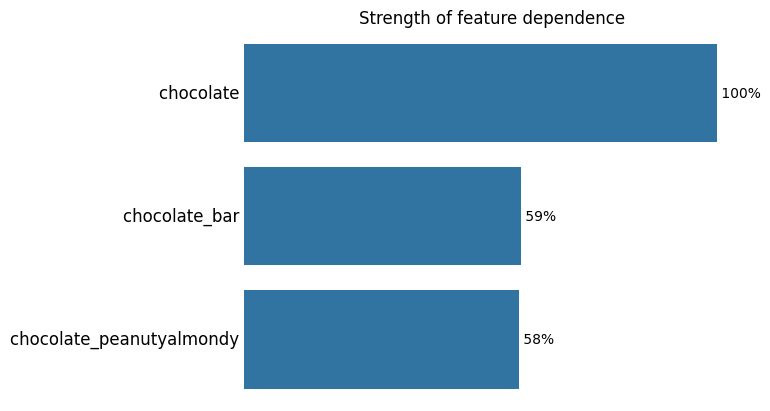

In [185]:
top_features = selected_features.feature[:3]
top_pvalues = selected_features.corrected_pvalue.values[:3]

importance_scores = -np.log10(top_pvalues)
importance_scores_normalized = importance_scores / np.max(importance_scores)
importance_scores_df = pd.DataFrame(dict(feature=top_features,
                                         importance=importance_scores_normalized))

ax = sns.barplot(importance_scores_df, x="importance", y="feature", orient='h')
ax.set(title="Strength of feature dependence", xlabel="Normalized P-value", ylabel=None)
ax.set_axis_off()
for i, feature in enumerate(top_features):
    ax.text(0, i, f"{feature} ", fontsize=12, va="center", ha="right")
    ax.text(importance_scores_normalized[i], i, f" {importance_scores_normalized[i]*100:.0f}%",
            fontsize=10, va="center", ha="left")

Chocolate is very strongly related to good candy, where as a chocolate bar or chocolate with peanuty/almondy flavors has high impact, too.